In [ ]:
# Import required libraries
import torch
import torch.nn as nn

class TimeSFM(nn.Module):
    def __init__(self, input_dim, factor_dim):
        super(TimeSFM, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
        self.v = nn.Parameter(torch.randn(input_dim, factor_dim))  # Factorization term

    def forward(self, x):
        # Linear term
        linear_part = self.linear(x)

        # Factorization Machine Interaction term
        interaction_term = 0.5 * torch.sum(
            torch.pow(torch.mm(x, self.v), 2) - torch.mm(torch.pow(x, 2), torch.pow(self.v, 2)),
            dim=1, keepdim=True
        )
        return linear_part + interaction_term

class TimeSFM_LSTM_Hybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden_size, factor_dim, num_lstm_layers):
        super(TimeSFM_LSTM_Hybrid, self).__init__()
        self.sfmlayer = TimeSFM(input_dim=input_dim, factor_dim=factor_dim)
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)  # Output layer

    def forward(self, x):
        # Apply TimeSFM for feature interactions
        sfm_output = self.sfmlayer(x)

        # Prepare data for LSTM
        lstm_input = sfm_output.unsqueeze(-1)  # Add an extra dimension for LSTM
        lstm_output, _ = self.lstm(lstm_input)

        # Final prediction layer
        out = self.fc(lstm_output[:, -1, :])  # Use last LSTM output
        return out

# Example usage
input_dim = 10
lstm_hidden_size = 64
factor_dim = 8
num_lstm_layers = 2

model = TimeSFM_LSTM_Hybrid(input_dim=input_dim, lstm_hidden_size=lstm_hidden_size, factor_dim=factor_dim, num_lstm_layers=num_lstm_layers)
sample_input = torch.randn(32, 10)  # Batch size of 32, 10 features
output = model(sample_input)
print(output)


tensor([[ 0.0162],
        [-0.0010],
        [ 0.0154],
        [ 0.0079],
        [-0.0005],
        [-0.0006],
        [ 0.0157],
        [-0.0176],
        [ 0.0008],
        [-0.0141],
        [ 0.0131],
        [-0.0040],
        [-0.0053],
        [ 0.0113],
        [ 0.0137],
        [ 0.0006],
        [-0.0156],
        [-0.0121],
        [ 0.0161],
        [ 0.0054],
        [ 0.0038],
        [ 0.0154],
        [ 0.0158],
        [-0.0017],
        [-0.0145],
        [ 0.0165],
        [-0.0106],
        [ 0.0152],
        [-0.0120],
        [ 0.0105],
        [ 0.0054],
        [ 0.0027]], grad_fn=<AddmmBackward0>)


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Define TimeSFM layer
class TimeSFM(nn.Module):
    def __init__(self, input_dim, factor_dim):
        super(TimeSFM, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
        self.v = nn.Parameter(torch.randn(input_dim, factor_dim))  # Factorization term

    def forward(self, x):
        linear_part = self.linear(x)
        interaction_term = 0.5 * torch.sum(
            torch.pow(torch.mm(x, self.v), 2) - torch.mm(torch.pow(x, 2), torch.pow(self.v, 2)),
            dim=1, keepdim=True
        )
        return linear_part + interaction_term

# Define Hybrid Model
class TimeSFM_LSTM_Hybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden_size, factor_dim, num_lstm_layers):
        super(TimeSFM_LSTM_Hybrid, self).__init__()
        self.sfmlayer = TimeSFM(input_dim=input_dim, factor_dim=factor_dim)
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        sfm_output = self.sfmlayer(x)
        lstm_input = sfm_output.unsqueeze(-1)
        lstm_output, _ = self.lstm(lstm_input)
        out = self.fc(lstm_output[:, -1, :])
        return out

# Load data from CSV or Yahoo Finance
def load_data_from_csv(file_path, feature_columns, target_column):
    data = pd.read_csv(file_path)
    X = data[feature_columns].values
    y = data[target_column].values.reshape(-1, 1)
    return X, y

def load_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    X = data[['Open', 'High', 'Low', 'Volume']].values
    y = data['Close'].values.reshape(-1, 1)
    return X, y

# Preprocess data
def preprocess_data(X, y):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32), scaler_y

# Train model
def train_model(model, dataloader, num_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for features, target in dataloader:
            optimizer.zero_grad()
            predictions = model(features)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Load data (choose one)
# X, y = load_data_from_csv('your_dataset.csv', ['feature1', 'feature2'], 'target')
X, y = load_data_from_yahoo('AAPL', '2022-01-01', '2023-01-01')

# Preprocess and create DataLoader
X_tensor, y_tensor, scaler_y = preprocess_data(X, y)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize and train hybrid model
input_dim = X_tensor.shape[1]
lstm_hidden_size = 64
factor_dim = 8
num_lstm_layers = 2
model = TimeSFM_LSTM_Hybrid(input_dim, lstm_hidden_size, factor_dim, num_lstm_layers)

train_model(model, dataloader)

# Save model
torch.save(model.state_dict(), 'hybrid_model.pth')


[*********************100%***********************]  1 of 1 completed


Epoch 1/50, Loss: 0.41063129901885986
Epoch 2/50, Loss: 0.22563298046588898
Epoch 3/50, Loss: 0.19245892763137817
Epoch 4/50, Loss: 0.15141431987285614
Epoch 5/50, Loss: 0.07516122609376907
Epoch 6/50, Loss: 0.05539211258292198
Epoch 7/50, Loss: 0.06330510228872299
Epoch 8/50, Loss: 0.05545400083065033
Epoch 9/50, Loss: 0.04456973448395729
Epoch 10/50, Loss: 0.05014001950621605
Epoch 11/50, Loss: 0.04304332286119461
Epoch 12/50, Loss: 0.032657451927661896
Epoch 13/50, Loss: 0.05577325448393822
Epoch 14/50, Loss: 0.04907821863889694
Epoch 15/50, Loss: 0.03270615264773369
Epoch 16/50, Loss: 0.038693055510520935
Epoch 17/50, Loss: 0.03540343418717384
Epoch 18/50, Loss: 0.02887464500963688
Epoch 19/50, Loss: 0.029402349144220352
Epoch 20/50, Loss: 0.03395221009850502
Epoch 21/50, Loss: 0.0285834651440382
Epoch 22/50, Loss: 0.0373481810092926
Epoch 23/50, Loss: 0.029519924893975258
Epoch 24/50, Loss: 0.029268797487020493
Epoch 25/50, Loss: 0.025753648951649666
Epoch 26/50, Loss: 0.015250087

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Define TimeSFM layer
class TimeSFM(nn.Module):
    def __init__(self, input_dim, factor_dim):
        super(TimeSFM, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
        self.v = nn.Parameter(torch.randn(input_dim, factor_dim))  # Factorization term

    def forward(self, x):
        linear_part = self.linear(x)
        interaction_term = 0.5 * torch.sum(
            torch.pow(torch.mm(x, self.v), 2) - torch.mm(torch.pow(x, 2), torch.pow(self.v, 2)),
            dim=1, keepdim=True
        )
        return linear_part + interaction_term

# Define Hybrid Model
class TimeSFM_LSTM_Hybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden_size, factor_dim, num_lstm_layers):
        super(TimeSFM_LSTM_Hybrid, self).__init__()
        self.sfmlayer = TimeSFM(input_dim=input_dim, factor_dim=factor_dim)
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        sfm_output = self.sfmlayer(x)
        lstm_input = sfm_output.unsqueeze(-1)
        lstm_output, _ = self.lstm(lstm_input)
        out = self.fc(lstm_output[:, -1, :])
        return out

# Load data from Yahoo Finance
def load_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    X = data[['Open', 'High', 'Low', 'Volume']].values
    y = data['Close'].values.reshape(-1, 1)
    return X, y

# Preprocess data
def preprocess_data(X, y):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32), scaler_y

# Train model
def train_model(model, dataloader, num_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for features, target in dataloader:
            optimizer.zero_grad()
            predictions = model(features)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Load Tesla stock data
X, y = load_data_from_yahoo('TSLA', '2022-01-01', '2023-01-01')

# Preprocess and create DataLoader
X_tensor, y_tensor, scaler_y = preprocess_data(X, y)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize and train hybrid model
input_dim = X_tensor.shape[1]
lstm_hidden_size = 64
factor_dim = 8
num_lstm_layers = 2
model = TimeSFM_LSTM_Hybrid(input_dim, lstm_hidden_size, factor_dim, num_lstm_layers)

train_model(model, dataloader)

# Save model
torch.save(model.state_dict(), 'hybrid_model.pth')


[*********************100%***********************]  1 of 1 completed


Epoch 1/50, Loss: 0.317430317401886
Epoch 2/50, Loss: 0.25005826354026794
Epoch 3/50, Loss: 0.13468560576438904
Epoch 4/50, Loss: 0.04739905893802643
Epoch 5/50, Loss: 0.0027650282718241215
Epoch 6/50, Loss: 0.010767498053610325
Epoch 7/50, Loss: 0.0033867324236780405
Epoch 8/50, Loss: 0.0028971119318157434
Epoch 9/50, Loss: 0.0022807095665484667
Epoch 10/50, Loss: 0.002345713786780834
Epoch 11/50, Loss: 0.0024110707454383373
Epoch 12/50, Loss: 0.0021470084320753813
Epoch 13/50, Loss: 0.002156901638954878
Epoch 14/50, Loss: 0.0023969763424247503
Epoch 15/50, Loss: 0.0030523655004799366
Epoch 16/50, Loss: 0.0034057931043207645
Epoch 17/50, Loss: 0.002046362031251192
Epoch 18/50, Loss: 0.0007422850467264652
Epoch 19/50, Loss: 0.0034029330126941204
Epoch 20/50, Loss: 0.0015087805222719908
Epoch 21/50, Loss: 0.002580523956567049
Epoch 22/50, Loss: 0.002008261391893029
Epoch 23/50, Loss: 0.001327033038251102
Epoch 24/50, Loss: 0.0007520973449572921
Epoch 25/50, Loss: 0.002328228671103716
Ep

In [ ]:
import yfinance as yf

# Download Tesla stock data
stock_data = yf.download('TSLA', start='2020-01-01', end='2023-01-01')

# Print a snippet to ensure data is loaded
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2020-01-02  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.104000  29.333332  29.364668  151995000
2020-01-07  31.270666  31.441999  30.224001  30.760000  268231500
2020-01-08  32.809334  33.232666  31.215334  31.580000  467164500


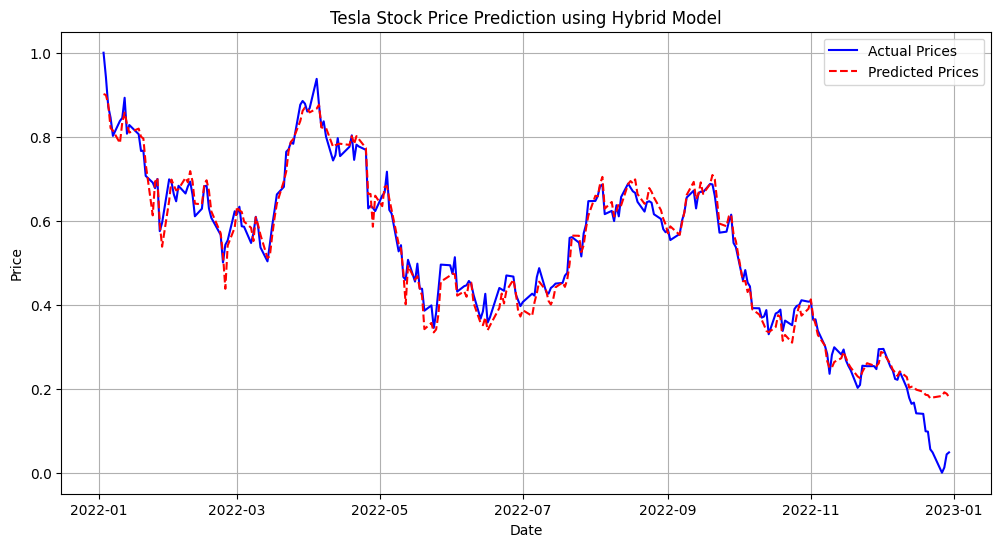

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions using the trained model
predicted_prices = model(X_tensor).detach().numpy()

# Use only the relevant number of dates from stock_data
dates = stock_data.index[-len(predicted_prices):]

# Extract actual prices for the corresponding dates
actual_prices = y_tensor.numpy()  # Ensure actual prices match tensor output

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label="Actual Prices", color='blue')
plt.plot(dates, predicted_prices, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Tesla Stock Price Prediction using Hybrid Model")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import numpy as np
# Import r2_score
from sklearn.metrics import r2_score

# Define TimeSFM layer
class TimeSFM(nn.Module):
    def __init__(self, input_dim, factor_dim):
        super(TimeSFM, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
        self.v = nn.Parameter(torch.randn(input_dim, factor_dim))  # Factorization term

    def forward(self, x):
        linear_part = self.linear(x)
        interaction_term = 0.5 * torch.sum(
            torch.pow(torch.mm(x, self.v), 2) - torch.mm(torch.pow(x, 2), torch.pow(self.v, 2)),
            dim=1, keepdim=True
        )
        return linear_part + interaction_term

# Define Hybrid Model
class TimeSFM_LSTM_Hybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden_size, factor_dim, num_lstm_layers):
        super(TimeSFM_LSTM_Hybrid, self).__init__()
        self.sfmlayer = TimeSFM(input_dim=input_dim, factor_dim=factor_dim)
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        sfm_output = self.sfmlayer(x)
        lstm_input = sfm_output.unsqueeze(-1)
        lstm_output, _ = self.lstm(lstm_input)
        out = self.fc(lstm_output[:, -1, :])
        return out

# Load data from Yahoo Finance
def load_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    X = data[['Open', 'High', 'Low', 'Volume']].values
    y = data['Close'].values.reshape(-1, 1)
    return data.index, X, y

# Preprocess data
def preprocess_data(X, y):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32), scaler_y

# Train model
def train_model(model, dataloader, num_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for features, target in dataloader:
            optimizer.zero_grad()
            predictions = model(features)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Error metrics
def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        'R2' : r2_score(actual_values, predicted_values),
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    }

    return pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])

# Load Tesla stock data
dates, X, y = load_data_from_yahoo('TSLA', '2022-01-01', '2023-01-01')

# Preprocess and create DataLoader
X_tensor, y_tensor, scaler_y = preprocess_data(X, y)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize and train hybrid model
input_dim = X_tensor.shape[1]
lstm_hidden_size = 64
factor_dim = 8
num_lstm_layers = 2
model = TimeSFM_LSTM_Hybrid(input_dim, lstm_hidden_size, factor_dim, num_lstm_layers)

train_model(model, dataloader)

# Predict on training data
with torch.no_grad():
    predictions = model(X_tensor).numpy()
    actuals = scaler_y.inverse_transform(y_tensor.numpy())
    predicted_prices = scaler_y.inverse_transform(predictions)

# Error metrics calculation
error_metrics_df = calculate_error_metrics(actuals.flatten(), predicted_prices.flatten())
print("\nError Metrics for TimeSFM-LSTM Hybrid Model on Tesla Stock:")
print(error_metrics_df)


[*********************100%***********************]  1 of 1 completed


Epoch 1/50, Loss: 0.14195002615451813
Epoch 2/50, Loss: 0.11951955407857895
Epoch 3/50, Loss: 0.07788508385419846
Epoch 4/50, Loss: 0.029836399480700493
Epoch 5/50, Loss: 0.021739507094025612
Epoch 6/50, Loss: 0.021369101479649544
Epoch 7/50, Loss: 0.015312845818698406
Epoch 8/50, Loss: 0.012818412855267525
Epoch 9/50, Loss: 0.014253810979425907
Epoch 10/50, Loss: 0.00959077849984169
Epoch 11/50, Loss: 0.0161023810505867
Epoch 12/50, Loss: 0.008595331571996212
Epoch 13/50, Loss: 0.007874877192080021
Epoch 14/50, Loss: 0.006036650389432907
Epoch 15/50, Loss: 0.007774489000439644
Epoch 16/50, Loss: 0.0035025139804929495
Epoch 17/50, Loss: 0.005078728776425123
Epoch 18/50, Loss: 0.008778720162808895
Epoch 19/50, Loss: 0.006288755219429731
Epoch 20/50, Loss: 0.008218575268983841
Epoch 21/50, Loss: 0.005762184504419565
Epoch 22/50, Loss: 0.0033761991653591394
Epoch 23/50, Loss: 0.0020618417765945196
Epoch 24/50, Loss: 0.006841361057013273
Epoch 25/50, Loss: 0.0054251509718596935
Epoch 26/50

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import numpy as np
from sklearn.metrics import r2_score

# Define TimeSFM layer
class TimeSFM(nn.Module):
    def __init__(self, input_dim, factor_dim):
        super(TimeSFM, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
        self.v = nn.Parameter(torch.randn(input_dim, factor_dim))  # Factorization term

    def forward(self, x):
        linear_part = self.linear(x)
        interaction_term = 0.5 * torch.sum(
            torch.pow(torch.mm(x, self.v), 2) - torch.mm(torch.pow(x, 2), torch.pow(self.v, 2)),
            dim=1, keepdim=True
        )
        return linear_part + interaction_term

# Define Hybrid Model
class TimeSFM_LSTM_Hybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden_size, factor_dim, num_lstm_layers):
        super(TimeSFM_LSTM_Hybrid, self).__init__()
        self.sfmlayer = TimeSFM(input_dim=input_dim, factor_dim=factor_dim)
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        sfm_output = self.sfmlayer(x)
        lstm_input = sfm_output.unsqueeze(-1)
        lstm_output, _ = self.lstm(lstm_input)
        out = self.fc(lstm_output[:, -1, :])
        return out

# Load data from Yahoo Finance
def load_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    X = data[['Open', 'High', 'Low', 'Volume']].values
    y = data['Close'].values.reshape(-1, 1)
    return data.index, X, y

# Preprocess data
def preprocess_data(X, y):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32), scaler_y

# Train model
def train_model(model, dataloader, num_epochs=100, learning_rate=0.001):  # Increased epochs for longer time series
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for features, target in dataloader:
            optimizer.zero_grad()
            predictions = model(features)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Error metrics
def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        'R2' : r2_score(actual_values, predicted_values),
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    }

    return pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])

# Load Reliance stock data (2000 to 2024)
dates, X, y = load_data_from_yahoo('RELIANCE.NS', '2000-01-01', '2024-01-01')

# Preprocess and create DataLoader
X_tensor, y_tensor, scaler_y = preprocess_data(X, y)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # Increased batch size

# Initialize and train hybrid model
input_dim = X_tensor.shape[1]
lstm_hidden_size = 128  # Increased LSTM hidden size for longer data
factor_dim = 16  # Increased factor dimension for complexity
num_lstm_layers = 3  # Increased layers for better sequence learning
model = TimeSFM_LSTM_Hybrid(input_dim, lstm_hidden_size, factor_dim, num_lstm_layers)

train_model(model, dataloader)

# Predict on training data
with torch.no_grad():
    predictions = model(X_tensor).numpy()
    actuals = scaler_y.inverse_transform(y_tensor.numpy())
    predicted_prices = scaler_y.inverse_transform(predictions)

# Error metrics calculation
error_metrics_df = calculate_error_metrics(actuals.flatten(), predicted_prices.flatten())
print("\nError Metrics for TimeSFM-LSTM Hybrid Model on Reliance Stock:")
print(error_metrics_df)


[*********************100%***********************]  1 of 1 completed


Epoch 1/100, Loss: 0.007787415757775307
Epoch 2/100, Loss: 0.0015437655383720994
Epoch 3/100, Loss: 0.0007492057047784328
Epoch 4/100, Loss: 0.0003744424902833998
Epoch 5/100, Loss: 0.00033899489790201187
Epoch 6/100, Loss: 0.00024803043925203383
Epoch 7/100, Loss: 8.37599509395659e-05
Epoch 8/100, Loss: 9.000734280562028e-05
Epoch 9/100, Loss: 9.158183092949912e-05
Epoch 10/100, Loss: 5.0635560910450295e-05
Epoch 11/100, Loss: 9.233289893018082e-05
Epoch 12/100, Loss: 4.055124009028077e-05
Epoch 13/100, Loss: 4.161095785093494e-05
Epoch 14/100, Loss: 0.0001228149194503203
Epoch 15/100, Loss: 2.317111830052454e-05
Epoch 16/100, Loss: 3.000664582941681e-05
Epoch 17/100, Loss: 1.6726835383451544e-05
Epoch 18/100, Loss: 4.6313834900502115e-05
Epoch 19/100, Loss: 2.1410589397419244e-05
Epoch 20/100, Loss: 4.137908763368614e-05
Epoch 21/100, Loss: 1.3873231182515156e-05
Epoch 22/100, Loss: 2.5699080651975237e-05
Epoch 23/100, Loss: 1.4286465557233896e-05
Epoch 24/100, Loss: 4.43984790763352

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import kagglehub

# Download Kaggle dataset
path = kagglehub.dataset_download("mahmoudshaheen1134/trades-dataset")
print("Path to dataset files:", path)

# Define TimeSFM layer
class TimeSFM(nn.Module):
    def __init__(self, input_dim, factor_dim):
        super(TimeSFM, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
        self.v = nn.Parameter(torch.randn(input_dim, factor_dim))  # Factorization term

    def forward(self, x):
        linear_part = self.linear(x)
        interaction_term = 0.5 * torch.sum(
            torch.pow(torch.mm(x, self.v), 2) - torch.mm(torch.pow(x, 2), torch.pow(self.v, 2)),
            dim=1, keepdim=True
        )
        return linear_part + interaction_term

# Define Hybrid Model
class TimeSFM_LSTM_Hybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden_size, factor_dim, num_lstm_layers):
        super(TimeSFM_LSTM_Hybrid, self).__init__()
        self.sfmlayer = TimeSFM(input_dim=input_dim, factor_dim=factor_dim)
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        sfm_output = self.sfmlayer(x)
        lstm_input = sfm_output.unsqueeze(-1)
        lstm_output, _ = self.lstm(lstm_input)
        out = self.fc(lstm_output[:, -1, :])
        return torch.sigmoid(out)  # Suitable for binary classification

# Load data from Kaggle dataset
def load_data_from_kaggle():
    file_path = f"{path}/trades.csv"  # Adjust if filename differs
    data = pd.read_csv(file_path)
    X = data[['accountAgeDays', 'numItems', 'paymentMethodAgeDays']].values
    y = data['label'].values.reshape(-1, 1)
    return X, y

# Preprocess data
def preprocess_data(X, y):
    scaler_x = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # For binary classification
    return torch.tensor(X_scaled, dtype=torch.float32), y_tensor

# Train model
def train_model(model, dataloader, num_epochs=100, learning_rate=0.001):
    criterion = nn.BCELoss()  # Binary Cross Entropy for classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for features, target in dataloader:
            optimizer.zero_grad()
            predictions = model(features)  # Do not squeeze here
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Load data
X, y = load_data_from_kaggle()

# Preprocess and create DataLoader
X_tensor, y_tensor = preprocess_data(X, y)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize and train hybrid model
input_dim = X_tensor.shape[1]
lstm_hidden_size = 128
factor_dim = 16
num_lstm_layers = 3
model = TimeSFM_LSTM_Hybrid(input_dim, lstm_hidden_size, factor_dim, num_lstm_layers)

train_model(model, dataloader)

# Predict on training data
with torch.no_grad():
    predictions = model(X_tensor).numpy().flatten()
    predicted_labels = (predictions >= 0.5).astype(int)

# Error metrics calculation
actual_labels = y_tensor.numpy().flatten()
print("\nClassification Report for TimeSFM-LSTM Hybrid Model:")
print(classification_report(actual_labels, predicted_labels))


Path to dataset files: /root/.cache/kagglehub/datasets/mahmoudshaheen1134/trades-dataset/versions/1
Epoch 1/100, Loss: 0.22893759608268738
Epoch 2/100, Loss: 0.013793399557471275
Epoch 3/100, Loss: 0.060379717499017715
Epoch 4/100, Loss: 0.015962332487106323
Epoch 5/100, Loss: 0.10232841968536377
Epoch 6/100, Loss: 0.09049765765666962
Epoch 7/100, Loss: 0.005675595719367266
Epoch 8/100, Loss: 0.008100700564682484
Epoch 9/100, Loss: 0.00759534677490592
Epoch 10/100, Loss: 0.05176456645131111
Epoch 11/100, Loss: 0.024954883381724358
Epoch 12/100, Loss: 0.03792247548699379
Epoch 13/100, Loss: 0.014031958766281605
Epoch 14/100, Loss: 0.0021165444049984217
Epoch 15/100, Loss: 0.024117575958371162
Epoch 16/100, Loss: 0.025624986737966537
Epoch 17/100, Loss: 8.319706103065982e-05
Epoch 18/100, Loss: 0.011705922894179821
Epoch 19/100, Loss: 0.005624136887490749
Epoch 20/100, Loss: 0.00016434893768746406
Epoch 21/100, Loss: 1.3241889064374845e-05
Epoch 22/100, Loss: 0.018144182860851288
Epoch 2

In [ ]:
# Updated preprocess_data function (for binary classification)
def preprocess_data(X, y):
    scaler_x = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Binary classification target
    return torch.tensor(X_scaled, dtype=torch.float32), y_tensor

# Load data
X, y = load_data_from_kaggle()

# Preprocess and create DataLoader
X_tensor, y_tensor = preprocess_data(X, y)  # No scaler_y is returned
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize and train hybrid model
input_dim = X_tensor.shape[1]
lstm_hidden_size = 128
factor_dim = 16
num_lstm_layers = 3
model = TimeSFM_LSTM_Hybrid(input_dim, lstm_hidden_size, factor_dim, num_lstm_layers)

train_model(model, dataloader)

# Predict on training data
with torch.no_grad():
    predictions = model(X_tensor).numpy()
    actuals = y_tensor.numpy()

# Error metrics calculation
error_metrics_df = calculate_error_metrics(actuals.flatten(), predictions.flatten())
print("\nError Metrics for TimeSFM-LSTM Hybrid Model on Kaggle Trades Dataset:")
print(error_metrics_df)

actual_labels = (actuals >= 0.5).astype(int).flatten()
predicted_labels = (predictions >= 0.5).astype(int).flatten()
print("\nClassification Report for TimeSFM-LSTM Hybrid Model:")
print(classification_report(actual_labels, predicted_labels))


Epoch 1/100, Loss: 0.018928974866867065
Epoch 2/100, Loss: 0.10307330638170242
Epoch 3/100, Loss: 0.00849723257124424
Epoch 4/100, Loss: 0.11374382674694061
Epoch 5/100, Loss: 0.046634797006845474
Epoch 6/100, Loss: 0.1283186972141266
Epoch 7/100, Loss: 0.0019053665455430746
Epoch 8/100, Loss: 0.01949869655072689
Epoch 9/100, Loss: 0.006077937316149473
Epoch 10/100, Loss: 0.013635021634399891
Epoch 11/100, Loss: 0.003711536293849349
Epoch 12/100, Loss: 0.0005311749991960824
Epoch 13/100, Loss: 0.0006042494205757976
Epoch 14/100, Loss: 0.0009399984846822917
Epoch 15/100, Loss: 0.00036615965655073524
Epoch 16/100, Loss: 0.0035177997779101133
Epoch 17/100, Loss: 2.6100664399564266e-05
Epoch 18/100, Loss: 0.002498763846233487
Epoch 19/100, Loss: 0.0052933162078261375
Epoch 20/100, Loss: 4.005754362879088e-06
Epoch 21/100, Loss: 0.0005730967968702316
Epoch 22/100, Loss: 0.025351883843541145
Epoch 23/100, Loss: 0.05190936475992203
Epoch 24/100, Loss: 0.003990016877651215
Epoch 25/100, Loss: 

NameError: name 'r2_score' is not defined